In [51]:
library(tidyverse)
library(caret)
library(mice)
library(DescTools)


Attaching package: 'DescTools'


The following objects are masked from 'package:caret':

    MAE, RMSE




In [3]:
trainspace <- read.csv("train.csv", na.strings = "")
testspace <- read.csv("test.csv", na.strings = "")

In [4]:
check.na <- function(df) apply(df, 2, function(x) sum(is.na(x)))

In [5]:
print(dim(trainspace))
print(dim(testspace))

[1] 3116945      22
[1] 2077964      21


In [6]:
df <- trainspace
head(df)

,id,class,cap.diameter,cap.shape,cap.surface,cap.color,does.bruise.or.bleed,gill.attachment,gill.spacing,gill.color,⋯,stem.root,stem.surface,stem.color,veil.type,veil.color,has.ring,ring.type,spore.print.color,habitat,season
,<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,0,e,8.80,f,s,u,f,a,c,w,⋯,NA,NA,w,NA,NA,f,f,NA,d,a
2,1,p,4.51,x,h,o,f,a,c,n,⋯,NA,y,o,NA,NA,t,z,NA,d,w
3,2,e,6.94,f,s,b,f,x,c,w,⋯,NA,s,n,NA,NA,f,f,NA,l,w
4,3,e,3.88,f,y,g,f,s,NA,g,⋯,NA,NA,w,NA,NA,f,f,NA,d,u
5,4,e,5.85,x,l,w,f,d,NA,w,⋯,NA,NA,w,NA,NA,f,f,NA,g,a
6,5,p,4.30,x,t,n,f,s,c,n,⋯,NA,NA,w,NA,n,t,z,NA,d,a


In [7]:
numeric.cols <- df %>% select(where(is.numeric))
categorical.cols <- df %>% select(where(is.character))
head(numeric.cols)
head(categorical.cols)

,id,cap.diameter,stem.height,stem.width
,<int>,<dbl>,<dbl>,<dbl>
1,0,8.80,4.51,15.39
2,1,4.51,4.79,6.48
3,2,6.94,6.85,9.93
4,3,3.88,4.16,6.53
5,4,5.85,3.37,8.36
6,5,4.30,5.91,8.20


,class,cap.shape,cap.surface,cap.color,does.bruise.or.bleed,gill.attachment,gill.spacing,gill.color,stem.root,stem.surface,stem.color,veil.type,veil.color,has.ring,ring.type,spore.print.color,habitat,season
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,e,f,s,u,f,a,c,w,NA,NA,w,NA,NA,f,f,NA,d,a
2,p,x,h,o,f,a,c,n,NA,y,o,NA,NA,t,z,NA,d,w
3,e,f,s,b,f,x,c,w,NA,s,n,NA,NA,f,f,NA,l,w
4,e,f,y,g,f,s,NA,g,NA,NA,w,NA,NA,f,f,NA,d,u
5,e,x,l,w,f,d,NA,w,NA,NA,w,NA,NA,f,f,NA,g,a
6,p,x,t,n,f,s,c,n,NA,NA,w,NA,n,t,z,NA,d,a


In [8]:
rank.plot <- function(df, col) {
    df %>%
        group_by(c = df[[col]]) %>%
        summarize(prop = n() / nrow(df)) %>%
        filter(prop > 0.01) %>%
        ggplot() +
            geom_col(aes(reorder(c, prop, decreasing = TRUE), prop, fill = c))
}

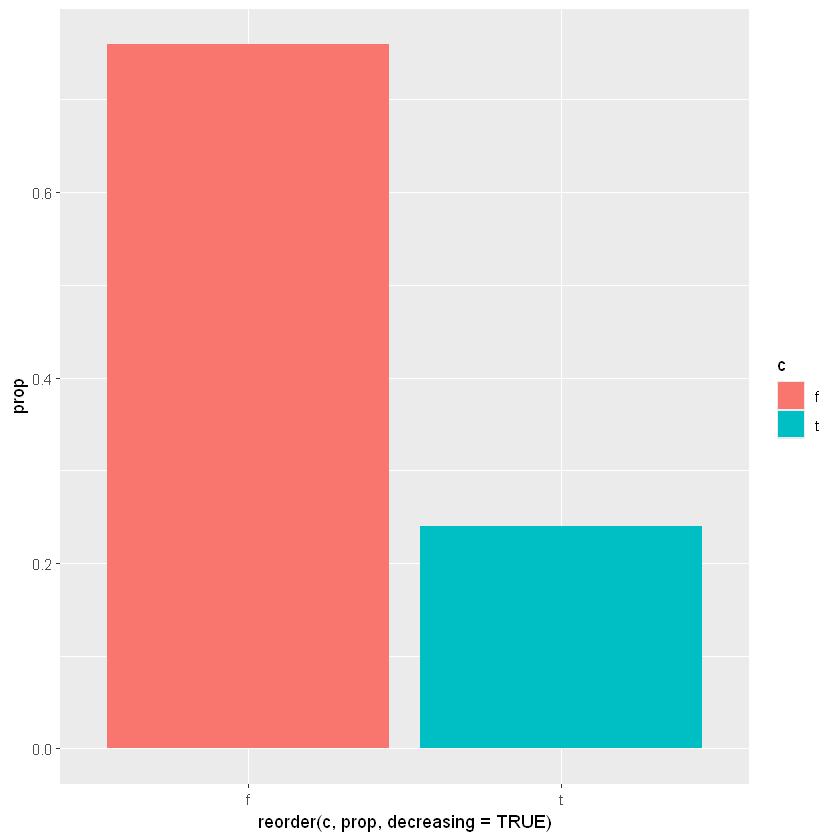

In [9]:
rank.plot(df, "has.ring")

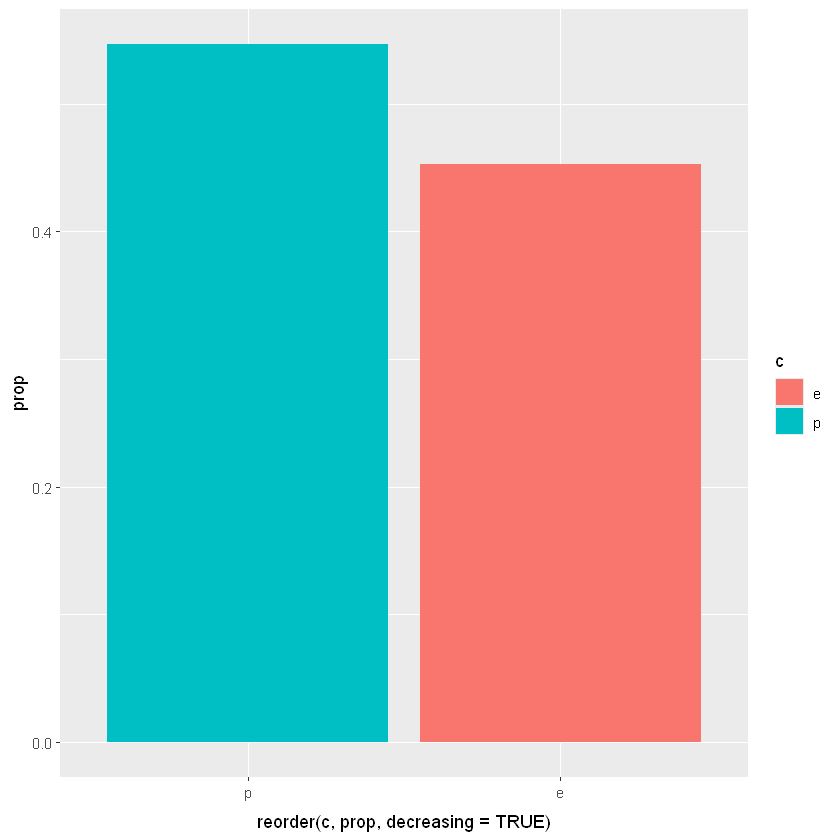

In [10]:
rank.plot(df, "class")

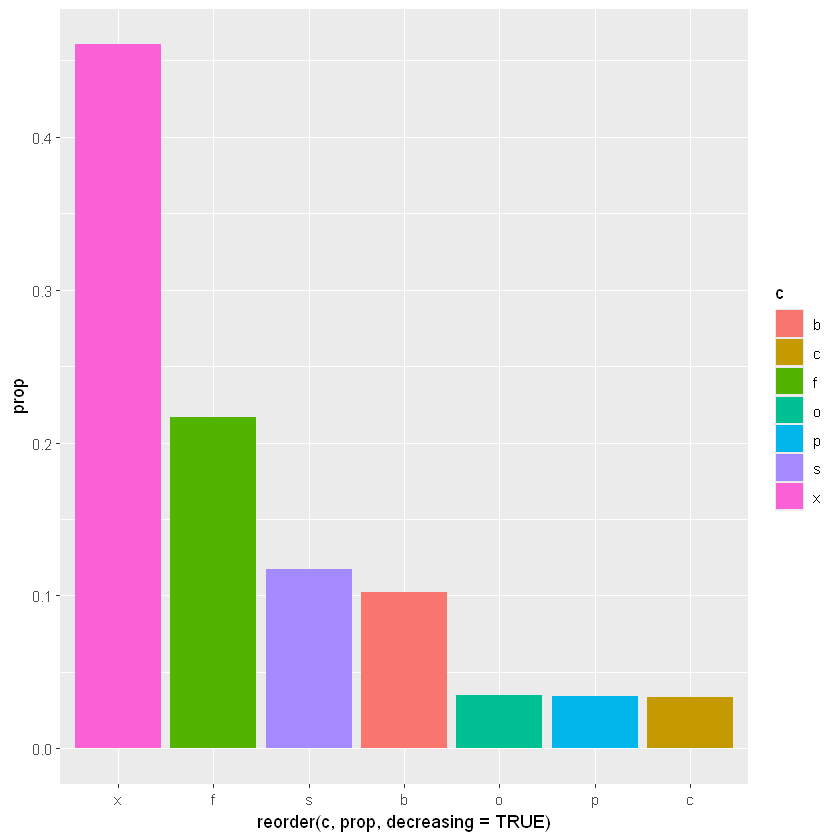

In [11]:
rank.plot(df, "cap.shape")

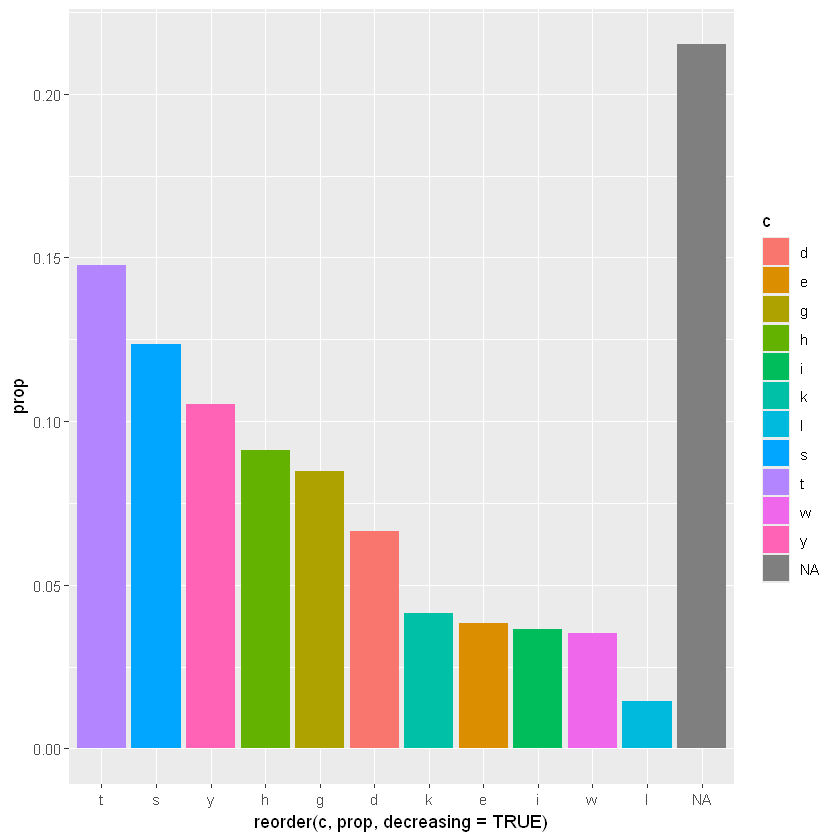

In [12]:
rank.plot(df, "cap.surface")

In [75]:
rank.encoding <- function(df, columns) {
    for (col in columns) {
        high.rank <- df %>% 
            group_by(c = df[[col]]) %>%
            summarize(prop = n() / nrow(df)) %>%
            filter(prop > 0.01)
        df[[col]] = ifelse(df[[col]] %in% high.rank$c, df[[col]], NA)
    }
    return (df)
}

In [14]:
categorical.rank <- rank.encoding(categorical.cols, colnames(categorical.cols))

Warning message:
"Removed 4 rows containing non-finite outside the scale range
(`stat_density()`)."


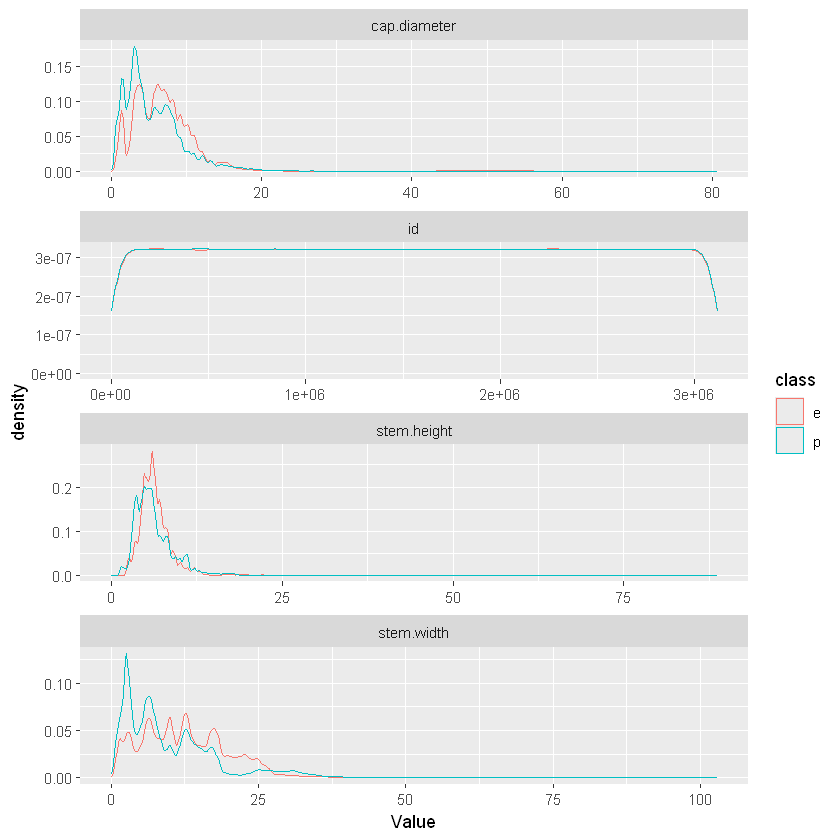

In [15]:
df %>%
    pivot_longer(cols = colnames(numeric.cols), names_to = "Numeric", values_to = "Value") %>%
    ggplot() +
        geom_density(aes(Value, color = class)) +
        facet_wrap(~ Numeric, scales = "free", ncol = 1)

Warning message:
"Removed 4 rows containing non-finite outside the scale range
(`stat_boxplot()`)."


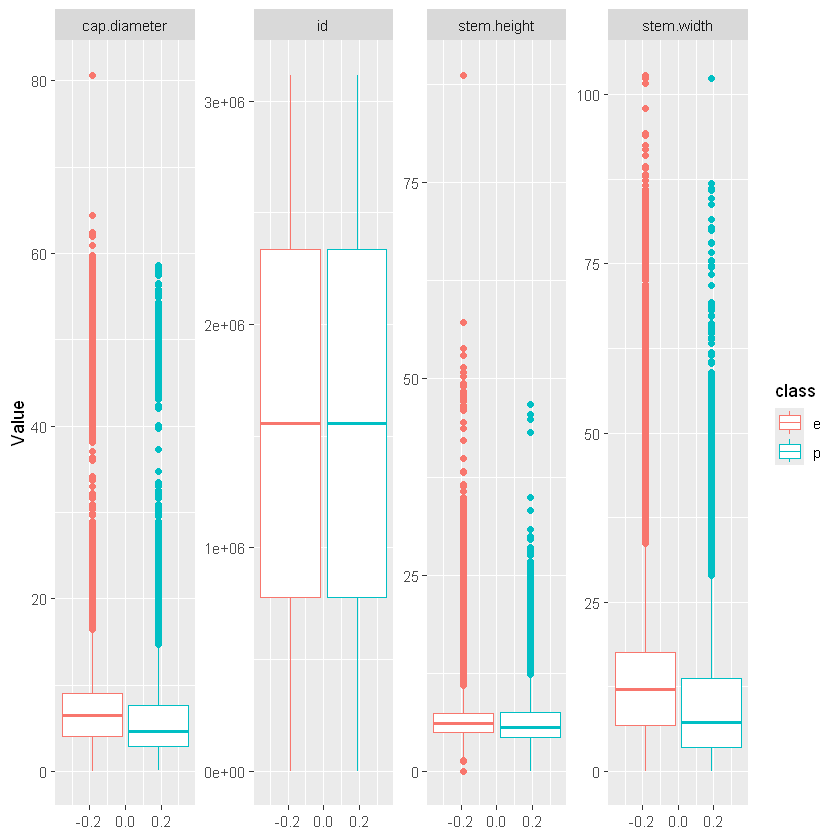

In [16]:
df %>%
    pivot_longer(cols = colnames(numeric.cols), names_to = "Numeric", values_to = "Value") %>%
    ggplot() +
        geom_boxplot(aes(y = Value, color = class)) +
        facet_wrap(~ Numeric, scales = "free", nrow = 1)

In [77]:
fill.numeric.median <- function(df) {
    df %>%
        mutate_if(is.numeric, function(x) replace_na(x, median(x, na.rm = TRUE)))
}

In [18]:
numeric.cols <- fill.numeric.median(numeric.cols)

In [19]:
clean.space <- cbind(numeric.cols, categorical.rank)
str(clean.space)

'data.frame':	3116945 obs. of  22 variables:
 $ id                  : int  0 1 2 3 4 5 6 7 8 9 ...
 $ cap.diameter        : num  8.8 4.51 6.94 3.88 5.85 4.3 9.65 4.55 7.36 6.45 ...
 $ stem.height         : num  4.51 4.79 6.85 4.16 3.37 ...
 $ stem.width          : num  15.39 6.48 9.93 6.53 8.36 ...
 $ class               : chr  "e" "p" "e" "e" ...
 $ cap.shape           : chr  "f" "x" "f" "f" ...
 $ cap.surface         : chr  "s" "h" "s" "y" ...
 $ cap.color           : chr  "u" "o" "b" "g" ...
 $ does.bruise.or.bleed: chr  "f" "f" "f" "f" ...
 $ gill.attachment     : chr  "a" "a" "x" "s" ...
 $ gill.spacing        : chr  "c" "c" "c" NA ...
 $ gill.color          : chr  "w" "n" "w" "g" ...
 $ stem.root           : chr  NA NA NA NA ...
 $ stem.surface        : chr  NA "y" "s" NA ...
 $ stem.color          : chr  "w" "o" "n" "w" ...
 $ veil.type           : chr  NA NA NA NA ...
 $ veil.color          : chr  NA NA NA NA ...
 $ has.ring            : chr  "f" "t" "f" "f" ...
 $ ring.type   

In [20]:
X <- clean.space %>% 
    select(-id, -class, -stem.root, -stem.surface, -veil.type, -veil.color, -spore.print.color) %>%
    mutate_if(is.character, as.factor)
y <- clean.space$class

In [71]:
fill.with.cap.diameter <- function(df) {
    return (
        data.frame(
            df %>% 
                group_by(cut_interval(cap.diameter, 5)) %>%
                fill(cap.surface) %>%
                fill(cap.shape) %>%
                fill(cap.color) %>%
                ungroup() %>%
                select(-contains("cut_interval"))
        )
    )
}

fill.color <- function(df) {
    return (
        data.frame(
            df %>%
                group_by(cap.color) %>%
                fill(gill.color) %>%
                fill(stem.color) %>%
                ungroup()
        )
    )
}
fill.gill <- function(df) {
    return (
        data.frame(
            df %>%
                group_by(cap.shape) %>%
                fill(gill.attachment) %>%
                ungroup() %>%
                group_by(gill.attachment) %>%
                fill(gill.spacing) %>%
                ungroup()
        )
    )
}

fill.ring <- function(df) {
    df$has.ring <- ifelse(is.na(df$ring.type) | df$ring.type == "f", "f", "t")
    return (
        df %>%
            group_by(has.ring) %>%
            fill(ring.type) %>%
            ungroup()
    )
}

fill.with.mode <- function(df, cols) {
    return (
        df %>%
            mutate_at(cols, function(x) replace_na(x, Mode(x, na.rm = TRUE)))
    )
}


In [73]:
newX <- X %>%
    fill.with.cap.diameter() %>%
    fill.color() %>%
    fill.gill() %>%
    fill.ring()
check.na(newX)

cap.diameter          stem.height           stem.width 
                   0                    0                    0 
           cap.shape          cap.surface            cap.color 
                   0                    0                    0 
does.bruise.or.bleed      gill.attachment         gill.spacing 
                 117                    0                   23 
          gill.color           stem.color             has.ring 
                   0                    0                    0 
           ring.type              habitat               season 
                   0                41466                    0

In [74]:
newX <- X %>%
    fill.with.mode(cols = c("does.bruise.or.bleed", "gill.spacing", "habitat"))

In [114]:
preprocess <- function(df) {
    df %>%
        rank.encoding(columns = colnames(df %>% select(where(is.character)))) %>%
        fill.numeric.median() %>%
        select(-id, -stem.root, -stem.surface, -veil.type, -veil.color, -spore.print.color) %>%
        fill.with.cap.diameter() %>%
        fill.color() %>%
        fill.gill() %>%
        fill.with.mode(cols = c("does.bruise.or.bleed", "gill.spacing", "habitat")) %>%
        mutate_if(is.character, as.factor) %>%
        mutate_if(is.factor, as.integer)
}

In [97]:
X <- preprocess(trainspace) %>% select(-class)
y <- ifelse(trainspace$class == "p", 1, 0)

In [98]:
test_ind <- createDataPartition(y, p = 0.3, list = FALSE)
X.test <- X[test_ind, ]
y.test <- y[test_ind]
X.train <- X[-test_ind, ]
y.train <- y[-test_ind]

In [102]:
X.test

,cap.diameter,cap.shape,cap.surface,cap.color,does.bruise.or.bleed,gill.attachment,gill.spacing,gill.color,stem.height,stem.width,stem.color,has.ring,ring.type,habitat,season
,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>
2,4.51,7,4,7,1,1,1,6,4.79,6.48,5,2,7,1,4
3,6.94,3,8,1,1,7,1,11,6.85,9.93,4,1,2,4,4
4,3.88,3,11,3,1,6,1,4,4.16,6.53,8,1,2,1,3
5,5.85,7,7,11,1,2,1,11,3.37,8.36,8,1,2,2,1
6,4.30,7,9,6,1,6,1,6,5.91,8.20,8,2,7,1,1
11,7.49,3,9,6,1,6,1,6,9.14,13.00,5,1,2,1,1
15,3.91,1,9,6,1,1,2,6,9.81,5.55,8,2,NA,2,3
18,9.87,5,3,6,1,5,1,8,10.03,33.03,4,1,2,1,3
20,7.43,6,1,6,2,2,1,12,6.21,9.49,1,1,2,1,1


In [99]:
library(xgboost)

In [103]:
X.train
y.train

,cap.diameter,cap.shape,cap.surface,cap.color,does.bruise.or.bleed,gill.attachment,gill.spacing,gill.color,stem.height,stem.width,stem.color,has.ring,ring.type,habitat,season
,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>
1,8.80,3,8,10,1,1,1,11,4.51,15.39,8,1,2,1,1
7,9.65,5,11,11,1,3,1,5,19.07,12.69,8,2,1,2,4
8,4.55,7,2,2,1,1,1,12,8.31,9.77,9,2,7,1,1
9,7.36,3,4,2,1,7,2,11,5.77,17.13,8,1,2,1,1
10,6.45,7,9,6,1,1,2,11,7.13,12.77,1,1,2,1,1
12,8.30,7,11,6,1,1,2,11,6.56,24.11,4,2,1,1,4
13,2.74,1,3,6,1,1,2,4,4.33,2.57,4,1,2,1,2
14,6.53,7,11,6,1,3,1,11,6.37,10.29,4,1,2,1,1
16,2.82,4,9,6,1,4,3,3,4.66,25.88,4,1,2,1,3


[1] 0 0 1 1 0 0 0 0 1 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 0 1 0 1 1 0 1 0 1 0 1
   [37] 1 1 0 0 0 0 0 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1
   [73] 1 1 0 0 1 0 1 1 0 1 1 0 1 1 1 1 0 0 0 1 0 1 1 0 1 0 0 1 1 1 1 1 0 1 1 1
  [109] 1 1 1 1 0 0 1 0 1 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 1 1
  [145] 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 0 0 1
  [181] 0 1 1 1 1 0 0 1 1 1 0 1 1 0 0 0 1 1 1 0 0 1 0 1 1 0 1 0 0 1 1 1 1 1 0 0
  [217] 0 1 1 0 1 0 0 1 0 0 0 1 0 0 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1
  [253] 0 0 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 1 0
  [289] 1 0 1 0 1 1 1 1 1 1 0 1 0 0 1 0 1 0 1 0 1 1 1 0 0 1 1 0 1 0 1 0 1 1 1 1
  [325] 1 1 1 0 0 0 1 1 1 0 1 1 1 0 1 0 1 0 0 0 0 1 1 1 1 0 0 1 0 1 1 0 1 1 0 1
  [361] 0 0 1 1 0 1 0 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 0 0 1 0 1 0
  [397] 0 0 0 1 0 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1
  [433] 1 0 1 1 0 0 0 1 1 0 0 0 1 0 1 1 0 1 0 1 1 0 1 1 1 0 0 1 1 0 1 1 1 0 1 1
  [469] 1 0 0 0 1 1 0 1 1 1 1 0 0 1 0 1 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 1 1 1
  [505] 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 0 1 0 0 1 0 0 0 1
  [541] 0 0 0 0 1 0 1 1 0 0 0 0 1 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0
  [577] 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 1 1 0 0 0 0 0
  [613] 0 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 0 1 1 1 1 0 1 0
  [649] 0 0 1 0 1 0 1 1 0 0 0 1 0 0 1 1 1 0 0 0 1 0 1 1 1 1 0 1 0 1 1 0 0 1 0 0
  [685] 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 0
  [721] 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 0 1 1 0 0 1 0 1 1 1 0 1 1 1 0 0 0 1 0 1
  [757] 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 0 0 0 1 1 1 0 1 1 0 0 1 0 0 0 1
  [793] 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 0 0 0 0 0 1 1 0 1 0 0 0
  [829] 1 1 0 0 0 0 1 1 1 0 0 1 0 0 1 1 1 1 1 0 0 1 0 0 0 1 0 1 1 1 0 0 0 1 0 0
  [865] 1 1 1 0 1 0 0 1 1 1 1 0 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1 1 0 1 0 0 0 1 1 0
  [901] 1 0 0 0 1 0 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 0 1 0 1 1 0
  [937] 0 1 0 0 0 1 0 1 0 1 0 1 1 0 1 0 0 1 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 1 0 0
  [973] 0 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 1
 [1009] 0 1 1 0 1 1 1 0 0 1 0 1 0 0 0 1 1 0 1 0 0 1 1 0 1 0 1 0 0 1 0 0 1 1 0 1
 [1045] 0 1 0 1 1 0 1 0 1 1 0 1 0 0 1 0 1 1 0 1 1 1 1 0 1 1 1 0 0 0 0 0 1 0 0 0
 [1081] 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0 1 1 1 1 1 0
 [1117] 1 1 1 0 1 0 0 1 0 0 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 0 0 1 0 1 0 0 0 1 0 1
 [1153] 1 1 0 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 0 1 1
 [1189] 1 1 1 0 1 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 1 0 1 1 0 0 0 1 0 1 0 1 0 1 0 1
 [1225] 0 1 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0
 [1261] 0 0 1 1 0 0 1 0 1 1 1 1 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1
 [1297] 1 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 1 1 1 0 0 0 1 0 0 1 1 0 0
 [1333] 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 0 0 0 0 1 0 1 0 1 0 0 0 1 1 1 1 0 1 0
 [1369] 0 0 0 1 1 1 1 1 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 1 0 1 1 1 1 0 1
 [1405] 0 0 1 0 0 1 1 0 0 1 0 1 1 0 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 0 0
 [1441] 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1
 [1477] 0 1 1 0 1 1 1 0 1 0 0 0 0 1 0 1 1 0 0 0 1 0 0 1 1 0 1 0 0 1 0 1 0 0 1 1
 [1513] 1 0 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 0 0 1 0 0 1 1 1 1 1 1 0 0 1 0 0 1 0 1
 [1549] 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1
 [1585] 1 1 1 0 0 0 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1 0 1 1 1 0 0 1 1 0 1 0 1 0 1
 [1621] 0 0 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 0 1 0 1 1 1 0 0
 [1657] 1 1 1 0 1 1 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 1 1 1 0 0 1 0
 [1693] 0 1 1 1 0 1 1 1 1 0 0 1 0 1 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0
 [1729] 1 0 0 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 0 0 1 0 0 1 0 1 0 0 0 0 1 1 1 0 1
 [1765] 0 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1
 [18

In [111]:
xg <- xgboost(data = as.matrix(X.train),
              label = y.train,
              params = list(
                eta = 0.3, 
                gamma = 0.04,
                subsample = 0.5
              ),
              nrounds = 70,
              objective = "binary:hinge")

[1]	train-error:0.452689 
[2]	train-error:0.433314 
[3]	train-error:0.385896 
[4]	train-error:0.217334 
[5]	train-error:0.170480 
[6]	train-error:0.149889 
[7]	train-error:0.124670 
[8]	train-error:0.103028 
[9]	train-error:0.092565 
[10]	train-error:0.084277 
[11]	train-error:0.073073 
[12]	train-error:0.066251 
[13]	train-error:0.056979 
[14]	train-error:0.048073 
[15]	train-error:0.040592 
[16]	train-error:0.038850 
[17]	train-error:0.037397 
[18]	train-error:0.035362 
[19]	train-error:0.034158 
[20]	train-error:0.029620 
[21]	train-error:0.027421 
[22]	train-error:0.025809 
[23]	train-error:0.025312 
[24]	train-error:0.023492 
[25]	train-error:0.023107 
[26]	train-error:0.022013 
[27]	train-error:0.021031 
[28]	train-error:0.020164 
[29]	train-error:0.019317 
[30]	train-error:0.018669 
[31]	train-error:0.018128 
[32]	train-error:0.018016 
[33]	train-error:0.017617 
[34]	train-error:0.017138 
[35]	train-error:0.016909 
[36]	train-error:0.016629 
[37]	train-error:0.016386 
[38]	train

In [112]:
pred <- predict(xg, as.matrix(X.test))
confusionMatrix(as.factor(pred), as.factor(y.test))

Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 418637   6511
         1   5208 504728
                                          
               Accuracy : 0.9875          
                 95% CI : (0.9872, 0.9877)
    No Information Rate : 0.5467          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9747          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9877          
            Specificity : 0.9873          
         Pos Pred Value : 0.9847          
         Neg Pred Value : 0.9898          
             Prevalence : 0.4533          
         Detection Rate : 0.4477          
   Detection Prevalence : 0.4547          
      Balanced Accuracy : 0.9875          
                                          
       'Positive' Class : 0               
            

In [115]:
test.input <- preprocess(testspace)

In [117]:
submission_5 <- data.frame(
    id = testspace$id,
    class = ifelse(predict(xg, as.matrix(test.input)) == 1, "p", "e")
)
write.csv(submission_5, "submission_5.csv", row.names = FALSE)